<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span>

***

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
!pip install scikit-learn

In [2]:
# Загрузим все необходимые библиотеки:
# загрузим pandas для работы с таблицами данных
import pandas as pd
# используем matplotlib для визуализации данных и построения графиков
import matplotlib.pyplot as plt 
# загрузим seaborn для визуализации данных и построения графиков
plt.style.use('ggplot')
import seaborn as sns 
# загрузим numpy для работы с многомерными массивами и матрицами
import numpy as np 
# загрузим statsmodels.tsa.seasonal для работы с временными рядами
from statsmodels.tsa.seasonal import seasonal_decompose
# загрузим sklearn.preprocessing для доступа функции для предварительной обработки данных
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, MinMaxScaler
# загрузим инструменты для разделения данных на обучающую и тестовую выборки, а также для выполнения кросс-валидации и настройки гиперпараметров
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, TimeSeriesSplit
# загрузим sklearn.metrics - метрики для оценки качества моделей
from sklearn.metrics import mean_squared_error
# загрузим sklearn.ensemble включающий классы для реализации ансамблевых моделей
from sklearn.ensemble import RandomForestRegressor
# загрузим sklearn.tree содержащий классы для реализации деревьев решений и решающих лесов
from sklearn.tree import DecisionTreeRegressor
# загрузим sklearn.linear_mode, который предоставляет классы для реализации линейных моделей, включая линейную регрессию
from sklearn.linear_model import LinearRegression
# загрузим lightgbm, который реализует алгоритм градиентного бустинга над деревьями LightGBM
import lightgbm as lgb
# загрузим xgboost - реализует алгоритм градиентного бустинга над деревьями XGBoost
import xgboost as xgb
# загрузим catboost - реализует алгоритм градиентного бустинга над деревьями CatBoost
from catboost import CatBoostRegressor
# загрузим time для измерения времени выполнения кода
from time import time
# загрузим progress bar для циклов - позволяет отслеживать прогресс выполнения операций
from tqdm import tqdm
# настроим отображение табалиц
pd.options.display.max_columns = None # полностью отображаем столбцы
from sklearn.ensemble import RandomForestRegressor

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [4]:
# локальный путь folder1/folder2/file.csv
df = pd.read_csv('datasets/taxi.csv')
display(df.head(), df.tail()) 

In [5]:
df.info()

Смотрим наличие дубликатов

In [6]:
print(df.duplicated().sum())
df = df.drop_duplicates().reset_index(drop=True)

In [7]:
# Преобразуем столбец 'datetime' в тип данных datetime с помощью функции pd.to_datetime()
df['datetime'] = pd.to_datetime(df['datetime'], format='%Y-%m-%d %H:%M:%S')
# Сортируе значения столбца 'datetime' в порядке возрастания с помощью метода sort_values()
df['datetime'] = df['datetime'].sort_values().reset_index(drop=True)

In [8]:
df.head()

Добавим график

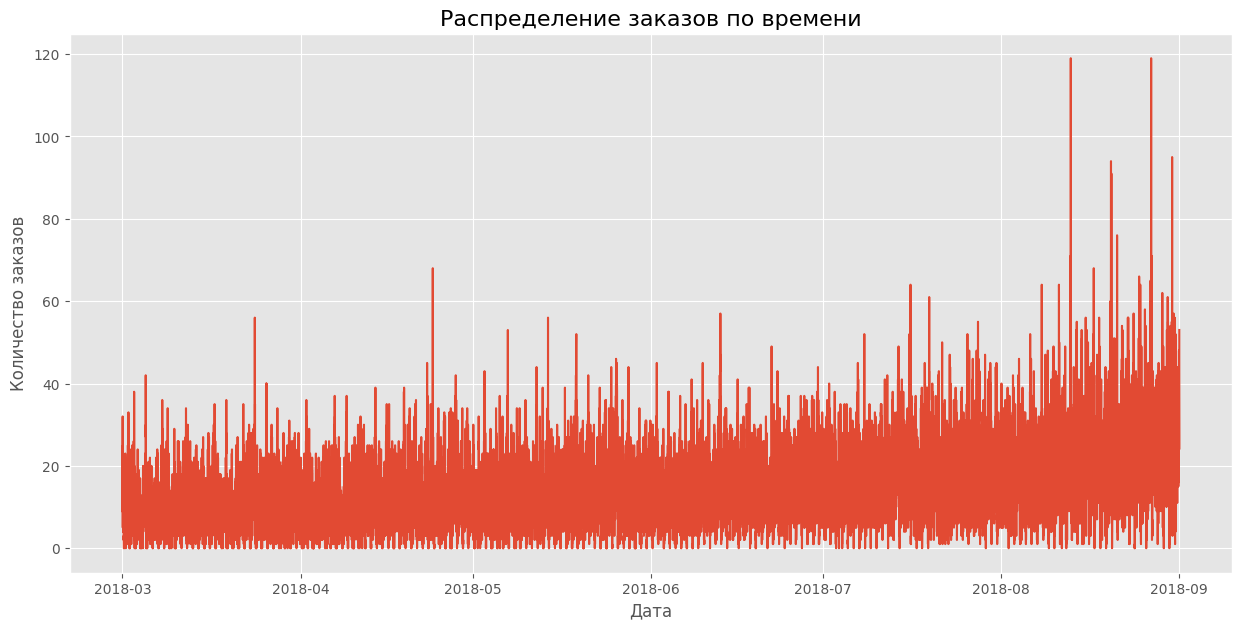

In [9]:
plt.figure(figsize=(15, 7))
plt.plot(df['datetime'], df['num_orders'])
plt.title('Распределение заказов по времени', fontsize=16)
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Количество заказов', fontsize=12)
plt.tick_params(axis='both', labelsize=10)
plt.grid(True)
plt.show()

Наши цели в задаче - прогноз заказов за час. Выполним ресемплирование по часу. В итоге будет количество заказов в час.

In [10]:
# установим 'datetime' в качестве индекса и ресемплируем данные на ежечасную частоту ('1H')
df = df.set_index(['datetime']).resample('1H').sum()
df.head()

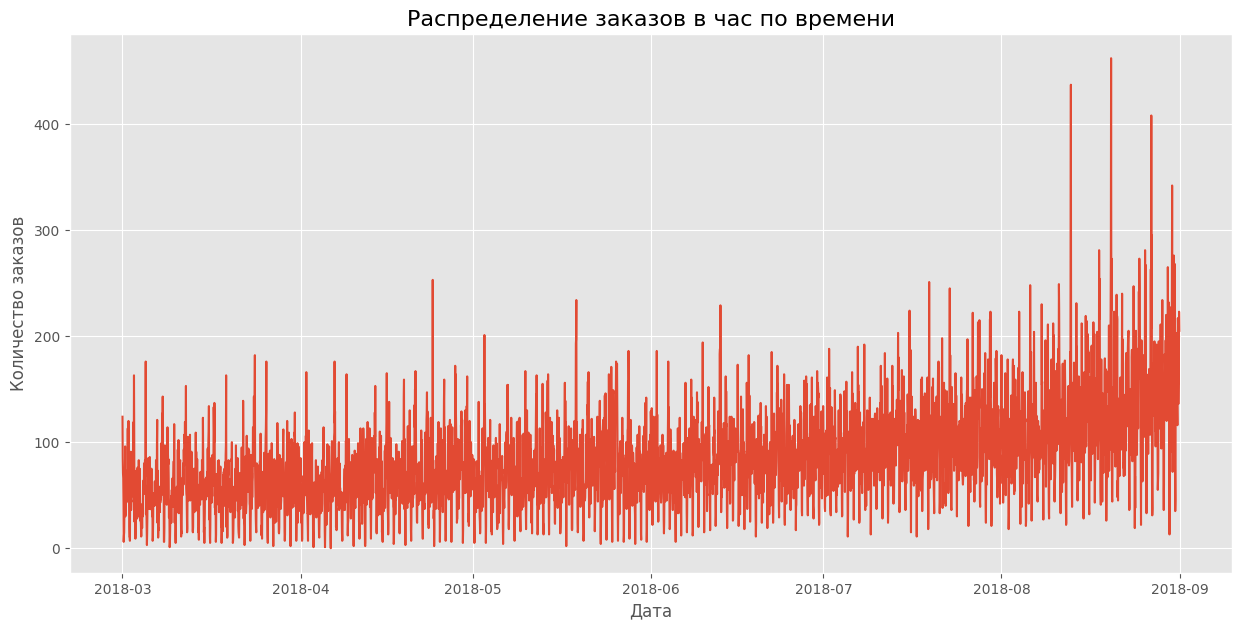

In [11]:
plt.figure(figsize=(15, 7))
plt.plot(df)
plt.title('Распределение заказов в час по времени', fontsize=16)
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Количество заказов', fontsize=12)
plt.tick_params(axis='both', labelsize=10)
plt.grid(True)
plt.show()

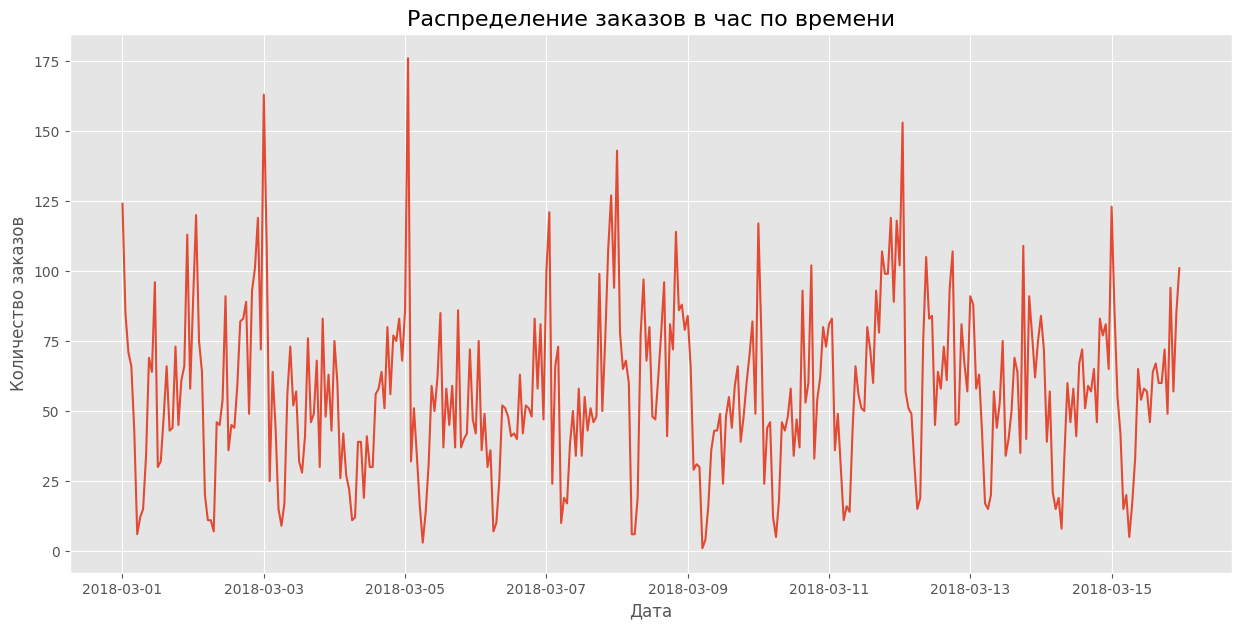

In [12]:
plt.figure(figsize=(15, 7))
plt.plot(df['2018-03-01':'2018-03-15'])
plt.title('Распределение заказов в час по времени', fontsize=16)
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Количество заказов', fontsize=12)
plt.tick_params(axis='both', labelsize=10)
plt.grid(True)
plt.show()

Данные готовы для дальнейшего анализа! Приступим 🤓



## Анализ

Данные подготовлены, и мы можем приступить к их анализу.

Анализ временных рядов
При анализе временных рядов мы рассмотрим несколько параметров:

 - Скользящее среднее  
Мы рассчитаем скользящее среднее, который является методом сглаживания временных рядов. Он основан на вычислении среднего значения в заданном окне, которое скользит по ряду. Этот метод позволяет уменьшить шумы и колебания в данных и выделить общий тренд.

 - Тренды и сезонность  
Мы проанализируем тренды, то есть долгосрочные изменения в ряде, и сезонность, которая отражает периодические колебания или паттерны в данных.

 - Стационарные ряды
Стационарные ряды - это ряды, у которых статистические свойства не меняются со временем. Мы будем исследовать стационарность данных и применять соответствующие методы анализа.

 - Разности временного ряда
Для стабилизации статистических свойств ряда мы будем использовать операцию разности между последовательными значениями ряда.



Скользящее среднее  

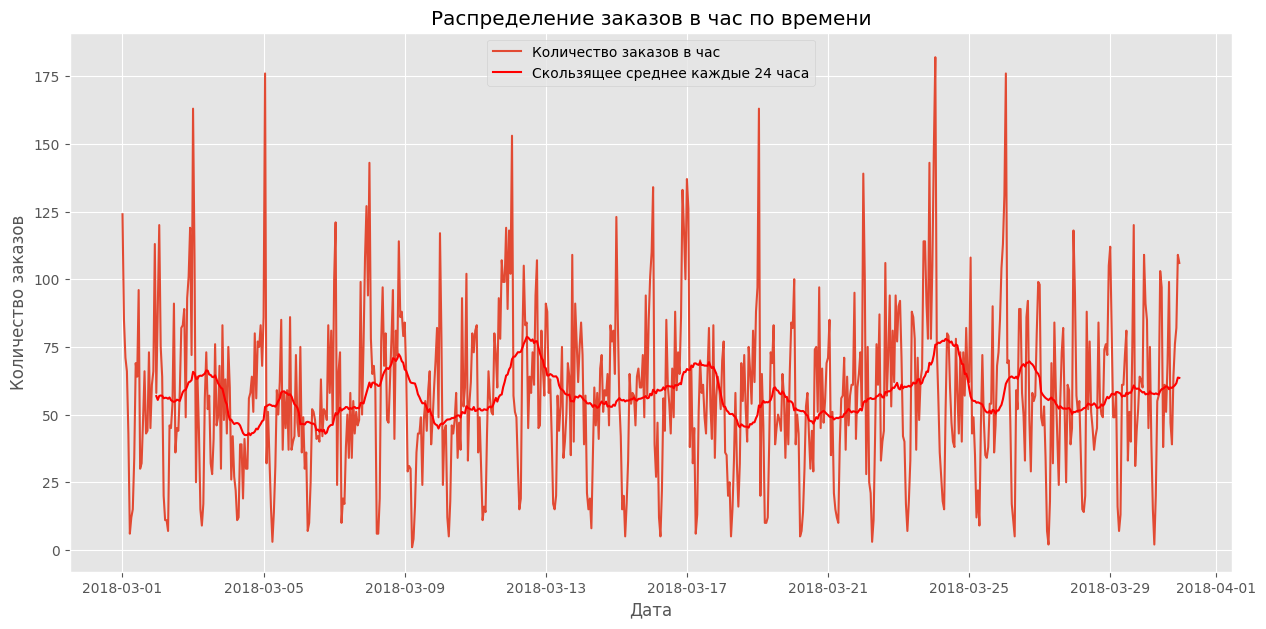

In [13]:
plt.figure(figsize=(15, 7))
# строим график количества заказов в час в указанном периоде
plt.plot(df['2018-03-01':'2018-03-30'])
# добавляет на график скользящее среднее каждые 24 часа
plt.plot(df['2018-03-01':'2018-03-30'].rolling(24).mean(), color='red')
plt.title('Распределение заказов в час по времени')
plt.legend(['Количество заказов в час', 'Скользящее среднее каждые 24 часа'])
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.show()

Тренд во временных рядах представляет собой долгосрочное изменение среднего значения ряда с течением времени. Он отражает общую направленность изменений в ряде на протяжении большого периода. Тренд может быть восходящим (при увеличении значений с течением времени), нисходящим (при уменьшении значений) или плоским (когда значения остаются стабильными).

Сезонность во временных рядах представляет собой повторяющиеся циклические закономерности или паттерны в данных. Эти закономерности возникают в определенные моменты времени и повторяются с некоторой регулярностью. Например, сезонность может проявляться в повторяющихся пиках или волнах активности, которые происходят в определенное время или в определенные сезоны года.

Важно отметить, что тренды и сезонность зависят от масштаба данных, которые рассматриваются. Если у нас есть данные только за один год, мы можем увидеть только годовую сезонность или долгосрочные тренды внутри этого года. Для выявления более длительных сезонных закономерностей или трендов требуются данные на более длительном временном интервале.

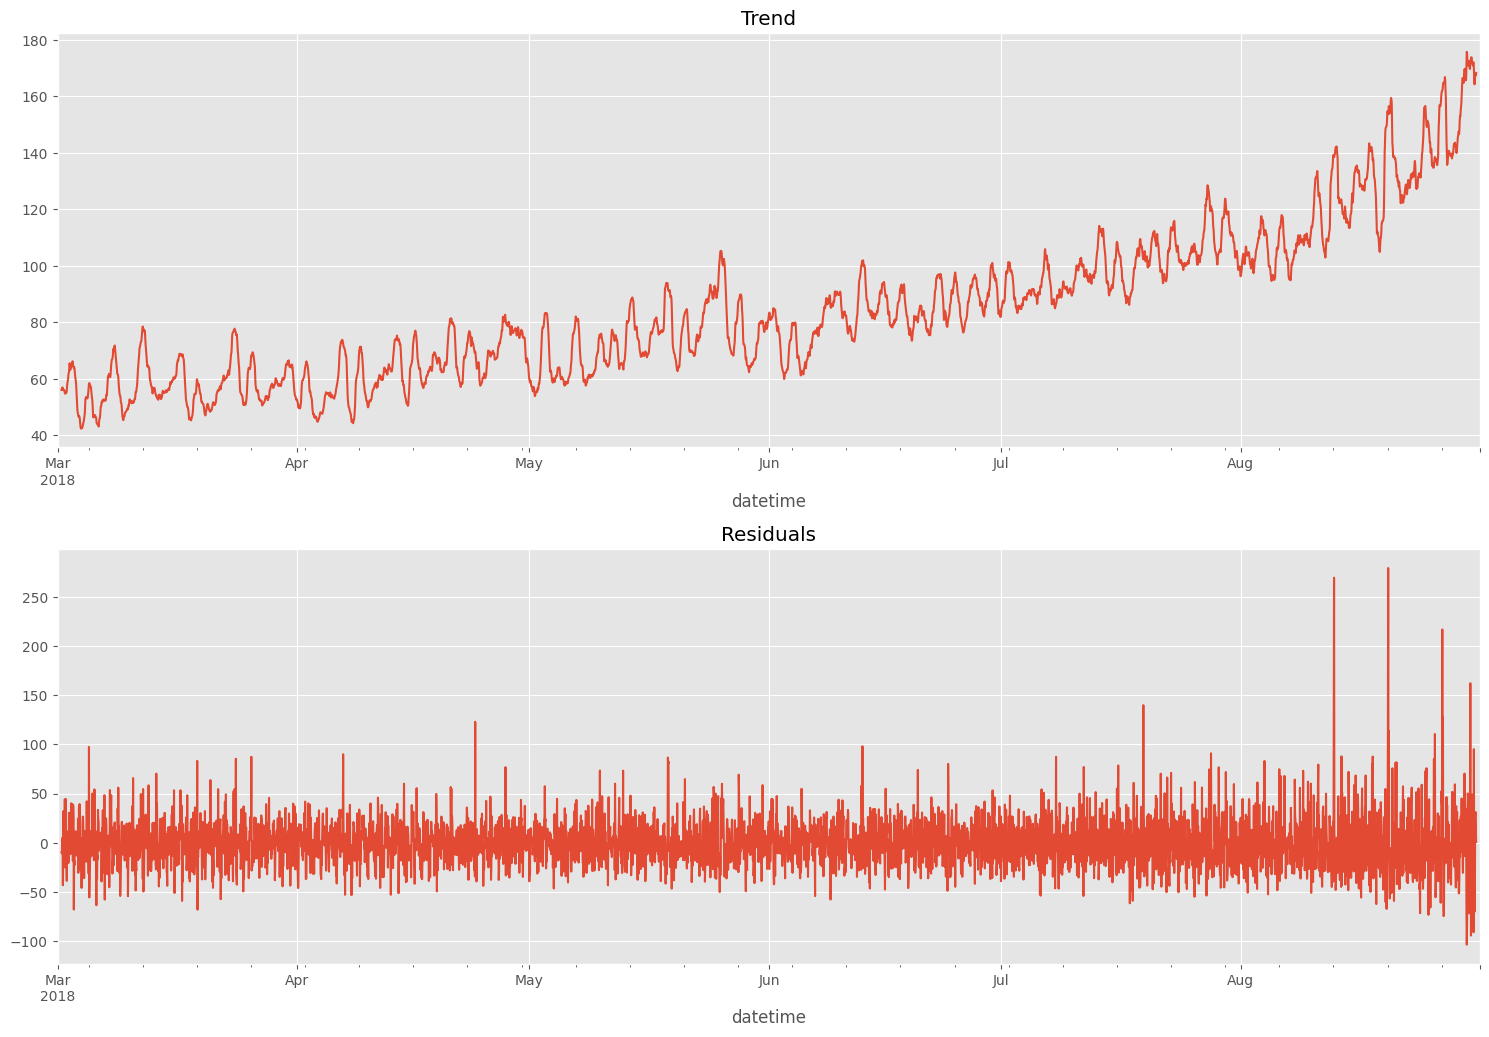

In [14]:
decomposed = seasonal_decompose(df)

plt.figure(figsize=(15, 15))
plt.subplot(311)
"""
Чтобы график корректно отобразился, указываем его
оси ax, равными plt.gca() (англ. get current axis,
получить текущие оси)
"""
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)

decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

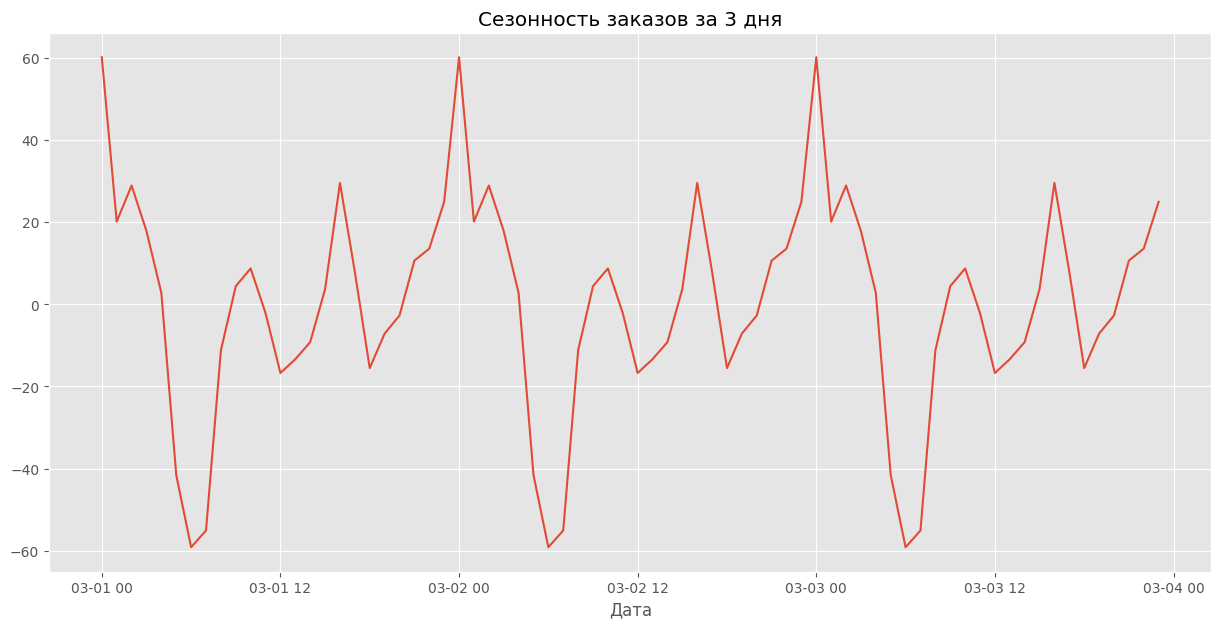

In [15]:
plt.figure(figsize=(15,7))
plt.plot(decomposed.seasonal['2018-03-01':'2018-03-3'])
plt.title('Сезонность заказов за 3 дня')
plt.xlabel('Дата')
plt.show()

Из графиков можно сделать следующий вывод:

Тренд: Количество заказов постепенно увеличивается со временем. Однако, так как данные охватывают всего полгода, нельзя сделать окончательные выводы о долгосрочных изменениях.  


Сезонность: В течение дня наблюдается сезонная вариация количества заказов. Минимум достигается примерно в 6 утра, а затем количество заказов постепенно увеличивается к концу дня.  


Шум: В данных есть случайные колебания, особенно заметные в конце летнего периода. Возможно, это связано с неконтролируемыми факторами или внешними воздействиями, которые могут повлиять на количество заказов.
Важно учитывать, что анализ короткого временного периода может быть ограниченным и не всегда достаточно информативным для сделанных выводов.


Стационарный ряд  
Найдём скользящее стандартное отклонение — стандартное отклонение по скользящему окну:  


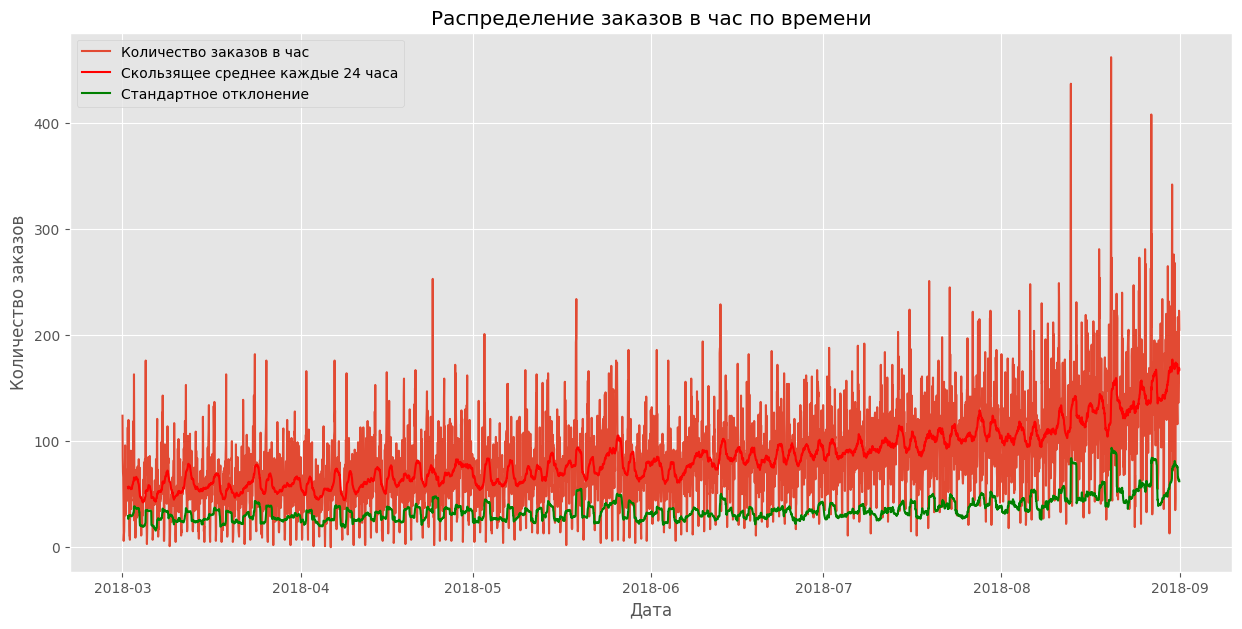

In [16]:
plt.figure(figsize=(15, 7))
plt.plot(df)
plt.plot(df.rolling(24).mean(), color='red')
plt.plot(df.rolling(24).std(), color='green')
plt.title('Распределение заказов в час по времени')
plt.legend(['Количество заказов в час', 'Скользящее среднее каждые 24 часа', 'Стандартное отклонение'])
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.show()

В статистике временные ряды описываются с использованием понятия стохастического процесса. Стохастический процесс представляет собой случайную величину, которая меняется со временем, и у неё изменяется распределение. У временного ряда есть среднее значение и дисперсия, которые также могут меняться во времени.

Процесс называется стационарным, если его статистические свойства (такие как распределение, среднее и дисперсия) не меняются со временем. Это означает, что статистические свойства процесса остаются постоянными независимо от времени. Если статистические свойства меняются, то процесс называется нестационарным.

Важно отметить, что распределение временного ряда обычно неизвестно и непросто определить. Поэтому в практическом анализе временных рядов стационарность обычно определяется на основе свойств среднего значения и стандартного отклонения ряда. Если среднее значение и стандартное отклонение ряда не меняются или меняются очень медленно, то ряд считается более стационарным.

Нестационарные временные ряды обычно более сложно прогнозировать, поскольку их статистические свойства меняются слишком быстро. Это может создавать сложности при моделировании и предсказании будущих значений ряда.

В данном случае, начальный период ряда с 2018-03 по 2018-08 считается стационарным, так как статистические свойства ряда в этом периоде меняются медленно или остаются постоянными. Однако, после этого периода ряд начинает изменяться и становится нестационарным. Это может иметь влияние на моделирование и прогнозирование ряда, поскольку его статистические свойства меняются.

Разность временного ряда  

Чтобы ряд сделать стационарным, найдём разности его значений.  

Разности временного ряда — это набор разностей между соседними элементами временного ряда, т. е. из каждого значения вычитается предыдущее.  

Построим графики разностей значений в указанном периоде, а также включим скользящее среднее и стандартное отклонение этих разностей. Это позволит анализировать изменения в значениях ряда и их стабильность со временем.

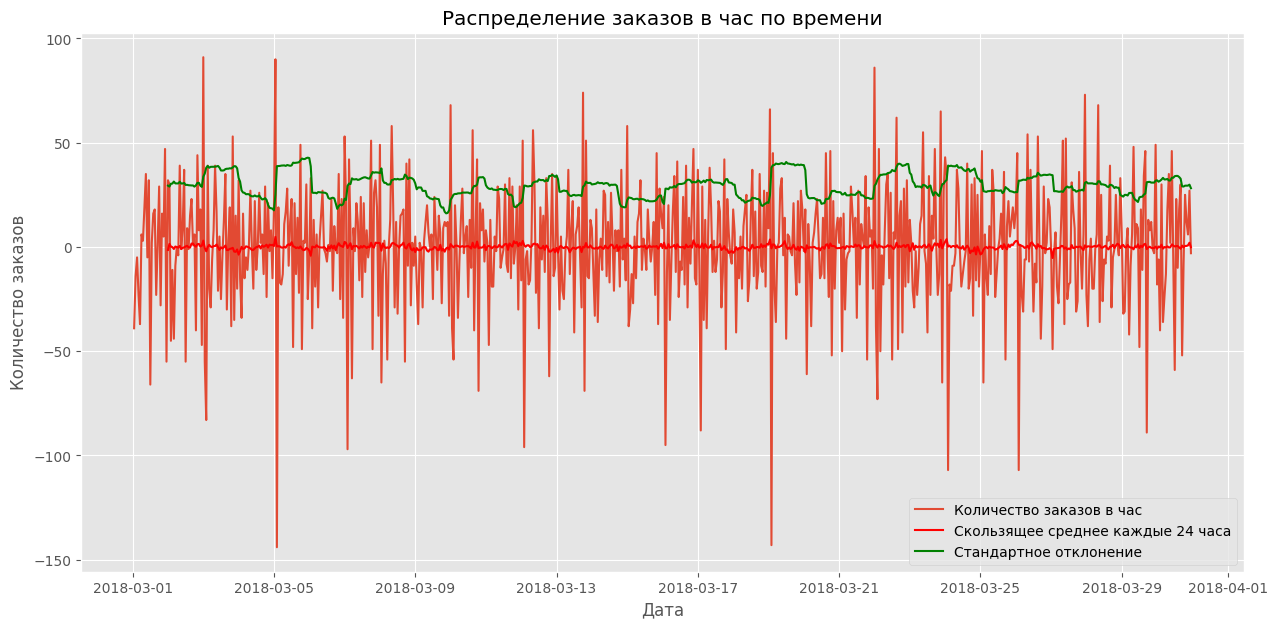

In [17]:
# создадим датафрейм, запишем в него значения, представляющие изменение между текущим и предыдущим периодами времени
shifted_df = df - df.shift()
# строим график разностей значений в периоде с 1 марта 2018 года по 30 марта 2018 года 
plt.figure(figsize=(15, 7))
plt.plot(shifted_df['2018-03-01':'2018-03-30'])
# добавим на график скользящее среднее значений разностей каждые 24 часа
plt.plot(shifted_df['2018-03-01':'2018-03-30'].rolling(24).mean(), color='red')
# добавим на график стандартное отклонение значений разностей каждые 24 часа
plt.plot(shifted_df['2018-03-01':'2018-03-30'].rolling(24).std(), color='green')
plt.title('Распределение заказов в час по времени')
plt.legend(['Количество заказов в час', 'Скользящее среднее каждые 24 часа', 'Стандартное отклонение'])
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.show()

По результатам полученного графика можно сделать вывод, что разность временного ряда (shifted_df) стала стационарной. Стационарность временного ряда означает, что статистические свойства ряда, такие как среднее значение и стандартное отклонение, остаются стабильными или меняются очень медленно со временем. В данном случае, разность временного ряда позволила стабилизировать статистические свойства и сделать ряд стационарным.

Если не удается получить необходимые метрики качества или применить стандартные методы анализа для исходного временного ряда, можно использовать разность ряда в качестве альтернативы. Разность временного ряда представляет собой изменение между последовательными значениями ряда, и она может быть более стационарной и поддаваться анализу.

Таким образом, после анализа данных и получения стационарного ряда (разности), можно приступить к обучению моделей и подбору гиперпараметров для прогнозирования временного ряда на основе стабильных статистических свойств разностного ряда.

## Обучение

Для подготовки данных мы напишем функцию для создания признаков, которая будет включать следующие типы признаков:

Календарные признаки: Во многих данных тренды и сезонность связаны с конкретной датой. Тип данных datetime64 в библиотеке Pandas уже содержит нужную информацию, поэтому нам просто нужно представить ее как отдельные столбцы. Мы можем извлечь информацию о годе, месяце, дне, дне недели и времени из столбца с датами и использовать их в качестве календарных признаков.

Отстающие значения:  

Предыдущие значения временного ряда могут указать, будет ли функция x(t) расти или уменьшаться. Мы можем добавить отстающие значения как признаки, представляющие предыдущие значения ряда на определенное количество временных шагов.

Скользящее среднее:   

Скользящее среднее как признак может указать на общий тренд временного ряда. Мы можем вычислить скользящее среднее на заданное окно и использовать его как признак.

В контексте данной задачи, поскольку количество заказов увеличивается в течение дня, мы возьмем максимальное отстающее значение равное 24 часам. Также мы вычислим скользящее среднее по 6 часам, так как заметно, что каждые 6 часов количество заказов как растет, так и падает.

Помимо этого, мы сразу разделим данные на обучающую и тестовую выборки, чтобы использовать их для обучения и оценки моделей прогнозирования.


Расширим исходный датафрейм data, добавив календарные признаки (день недели и час), отстающие значения ряда на различных временных лагах и скользящее среднее значений ряда. Эти признаки будут использоваться для обучения моделей прогнозирования.

In [18]:
# создаём функцию
def make_features(data, max_lag, rolling_mean_size):
    #  0 соответствует понедельнику, а 6 - воскресенью.
    data['dayofweek'] = data.index.dayofweek
    #  добавим столбец 'hour', значения часа в котором представлены числами от 0 до 23.
    data['hour'] = data.index.hour
    # создаем отстающие значения временного ряда 'num_orders' на различных временных лагах
    for lag in range(1, max_lag + 1):
        # смещаем значения ряда на указанный лаг, чтобы получить предыдущие значения временного ряда
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    # создаем признак 'rolling_mean', который представляет скользящее среднее значений временного ряда 'num_orders'
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()


In [19]:
# создаём новые фичи
make_features(df, 1, 24)

# разделим выборки и проверим их порядочность
train, test = train_test_split(df, shuffle=False, test_size=0.1)
train = train.dropna()

print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())

train_features = train.drop('num_orders', axis=1)
train_target = train['num_orders']
test_features = test.drop('num_orders', axis=1)
test_target = test['num_orders']


Данные подготовлены, исследуем модели (для подбора параметра split и вывод графиков сравнения на первых 7 днях):

In [20]:
# Cоздаём таблицу для анализа
analisys = pd.DataFrame({'model':[], 'RMSE_model':[], 'RMSE_on_train':[]})
all_models = []

# Cоздаём функцию для подбора параметров
def train_model(model, parameters):
    
    best_rmse = 1000
    best_splits = 0
    best_model = 0
    
    start = time()
    for split in range(6, 25, 2):
        tscv = TimeSeriesSplit(n_splits=split)
        model_random = GridSearchCV(estimator=model,
                                    param_grid=parameters,
                                    scoring='neg_mean_absolute_error',
                                    n_jobs=-1,
                                    cv=tscv, 
                                    verbose=1)
        model_random.fit(train_features, train_target)
        rmse = model_random.best_score_ * -1 ** 0.5
        if rmse < best_rmse:
            best_rmse = rmse
            best_splits = split
            best_model = model_random
    print('GridSearchCV подбирал сплиты и параметры %.2f секунд' %(time() - start))
    print('Лучшие число сплитов:', best_splits)
    
    model_random = best_model
    
    # высчитаем метрики
    rmse = model_random.best_score_ * -1 ** 0.5
    rmse_on_train = mean_squared_error(train_target, model_random.predict(train_features), squared=False)
    
    print('Лучшие параметры:', model_random.best_params_)
    print('RMSE обученной модели:', rmse)
    print('RMSE на тренировочной выборке:', rmse_on_train)
    
    predicted = pd.DataFrame(model_random.predict(train_features), index=train_features.index)
    plt.figure(figsize=(15,7))
    plt.plot(train_target[:'2018-03-07'], color='green', alpha=0.7)
    plt.plot(predicted[:'2018-03-07'], color='red', alpha=0.7)
    plt.title('Сравнение предсказаний на трейне модели за первые 7 дней')
    plt.ylabel('Количество заказов')
    plt.xlabel('Дата')
    plt.legend(['Реальные', 'Предсказанные'])
    plt.show()
    
    # Заполним все таблицы    
    all_models.append(model_random)
    row = []
    row.extend([model, rmse, rmse_on_train])
    analisys.loc[len(analisys.index)] = row
    
    return model_random

DecisionTreeRegressor (Регрессор на основе дерева решений). Попробуем эту модель машинного обучения, которая использует дерево решений для решения задачи регрессии. 

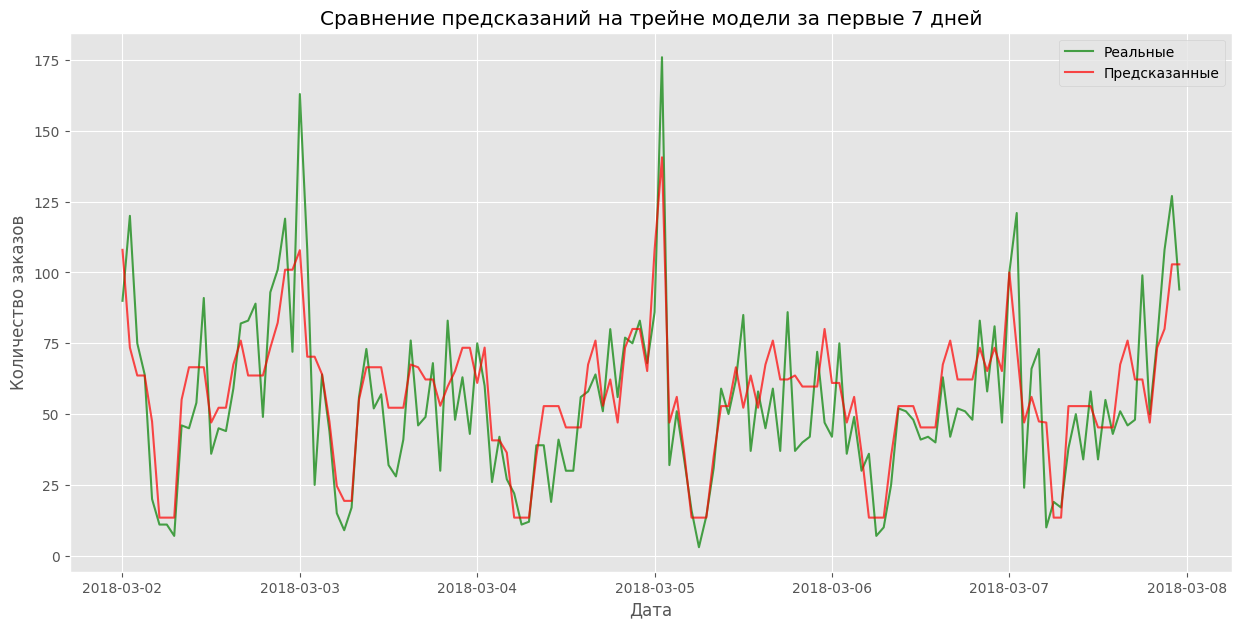

In [21]:
# Зададим рандомные параметры

ran_grid_tree = {"max_depth": list(range(3, 12))}

dtr = DecisionTreeRegressor()

dtr_random = train_model(dtr, ran_grid_tree) # обучим и сохраним значения

RandomForestRegressor (Регрессор на основе случайного леса). Применим эту ансамблевую модель машинного обучения, основанную на применении множества деревьев решений. 

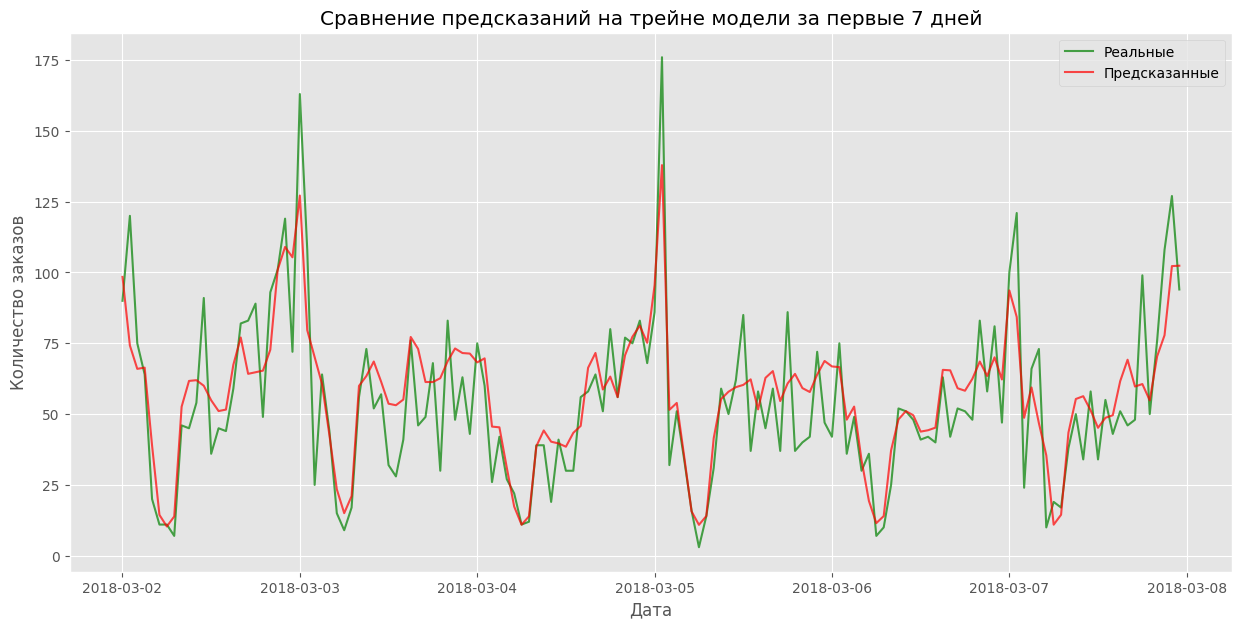

In [22]:
# Зададим рандомные параметры

ran_grid_forest = {
    'max_depth': list(range(2, 9)),
    'n_estimators': [50, 100, 200, 300]
}

rfr = RandomForestRegressor(n_jobs=-1)

rfr_random = train_model(rfr, ran_grid_forest) # обучим и сохраним значения

LGBMRegressor (Регрессор на основе градиентного бустинга с использованием гистограммных методов). Применим модель машинного обучения, основанную на градиентном бустинге и оптимизированную для работы с большими наборами данных.


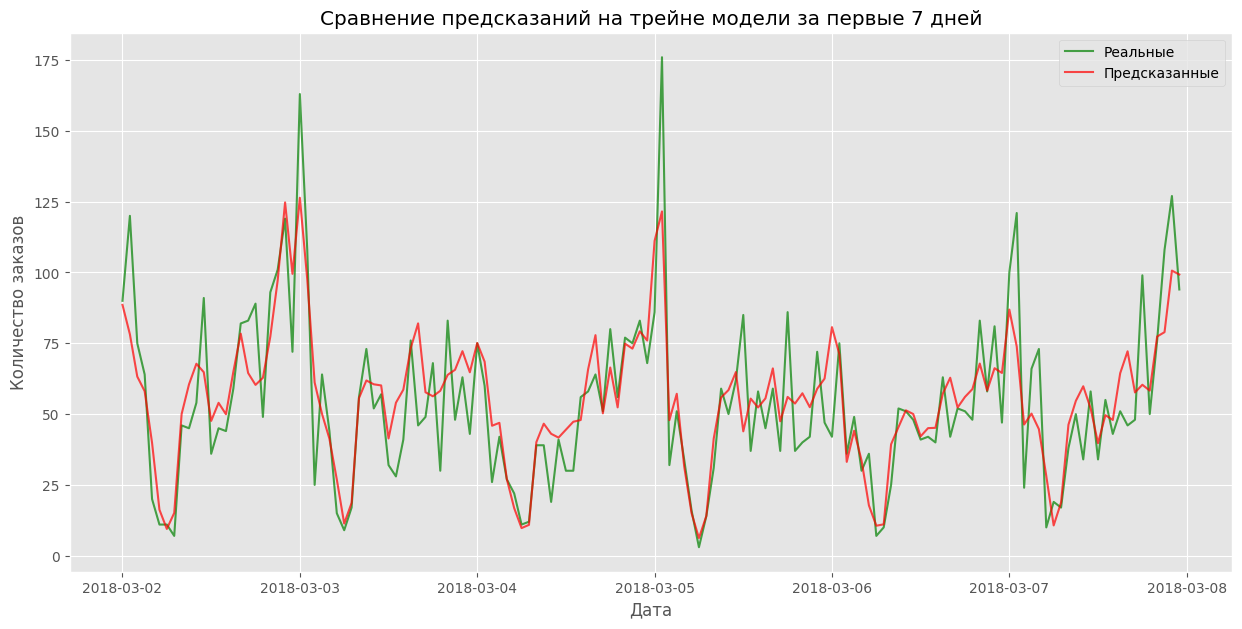

In [23]:
rand_lgbm_param = {
    'max_depth': [5, 10, 15, 25, 35],
    'learning_rate': [0.01, 0.1, 0.15]
}

gbm = lgb.LGBMRegressor(boosting_type='gbdt',
                         objective = 'regression',
                         metric = 'RMSE')

gbm_random = train_model(gbm, rand_lgbm_param)

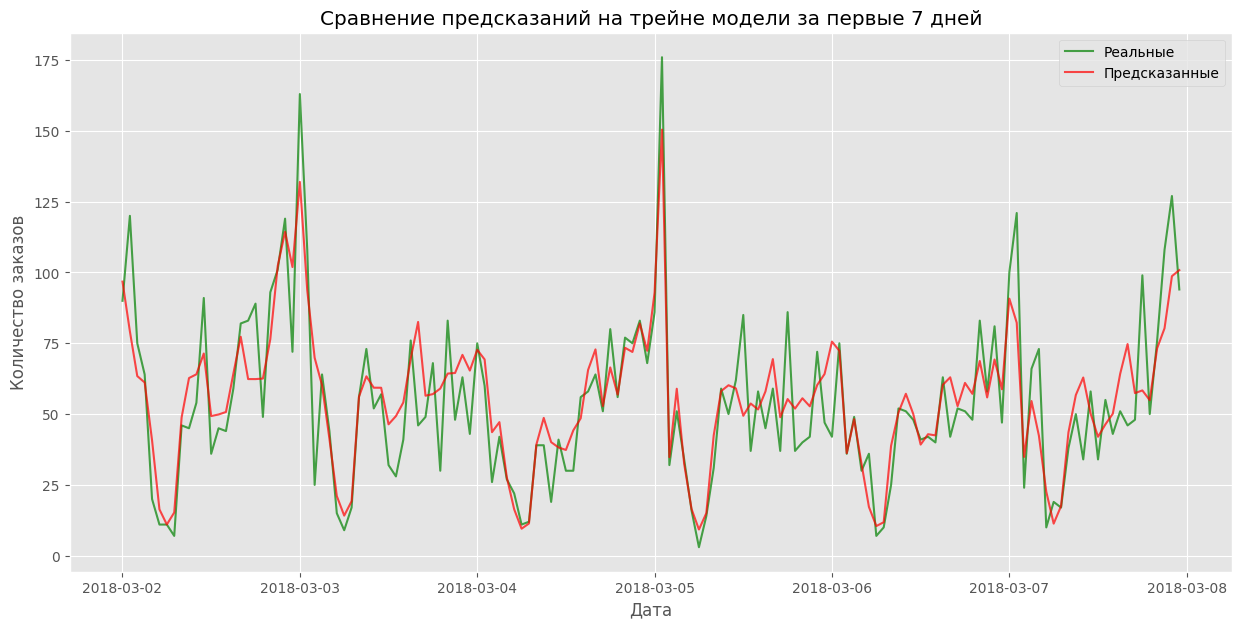

In [24]:
rand_xgb_param = {
    'max_depth': [1, 2, 3, 4, 5, 6, 7, 8],
    'learning_rate': [0.1, 0.15, 0.3]
}

xb = xgb.XGBRegressor(booster='gbtree', 
                      eval_metric='rmse', 
                      use_rmm=True,
                     verbosity=0)

xb_random = train_model(xb, rand_xgb_param)

XGBRegressor (Регрессор на основе градиентного бустинга с использованием распределенного градиентного подхода). Модель машинного обучения, которая использует градиентный бустинг для предсказания непрерывных (числовых) значений. 

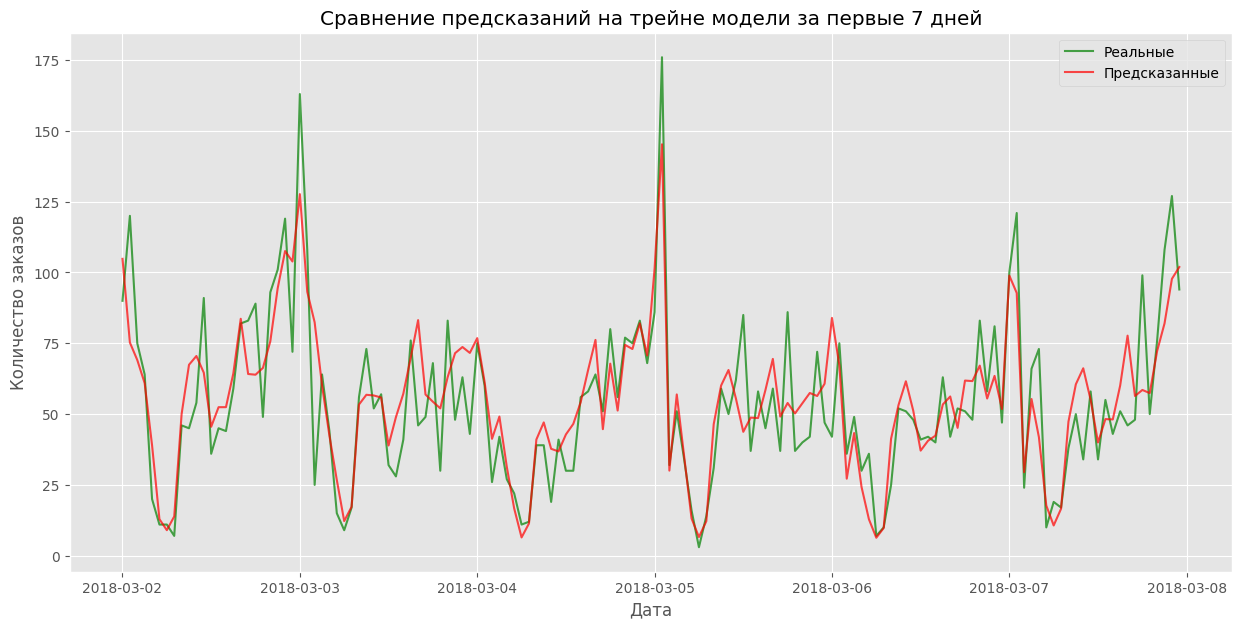

In [25]:
rand_cat_param = {
    'max_depth': [1, 2, 3, 4, 5],
    'learning_rate': [0.1, 0.2]
}

cat = CatBoostRegressor(verbose=False) 
#                         task_type='GPU') 

cat_random = train_model(cat, rand_cat_param)

Ну и сравним по итогу!

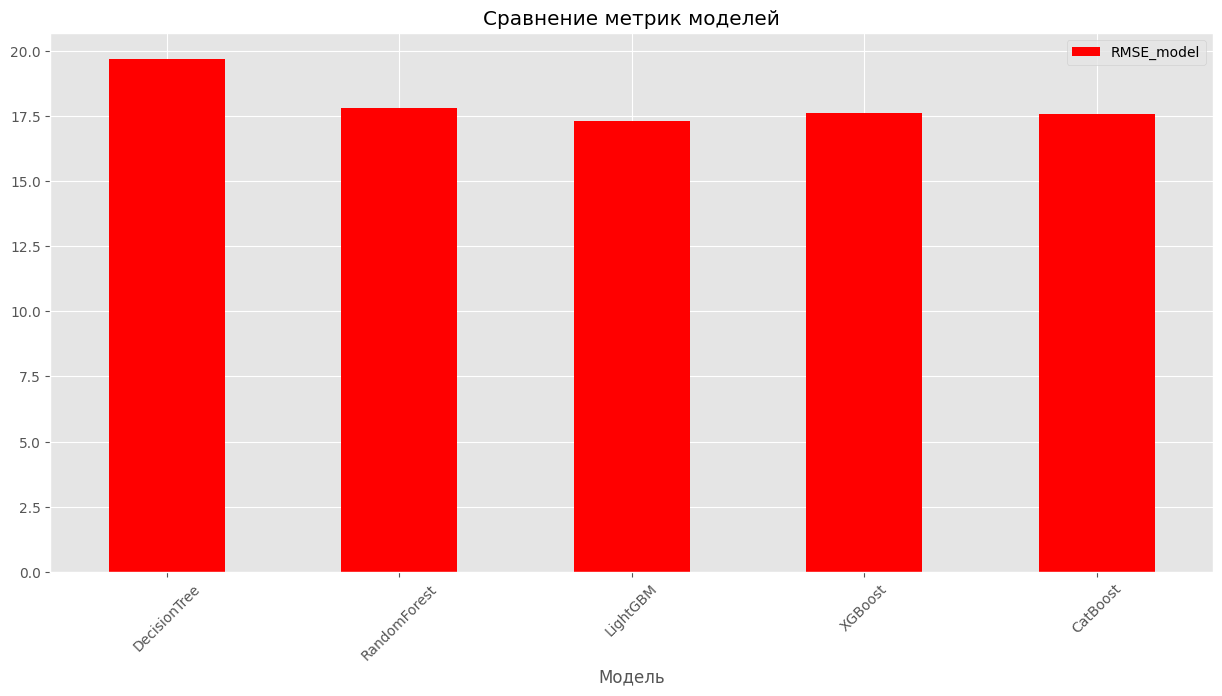

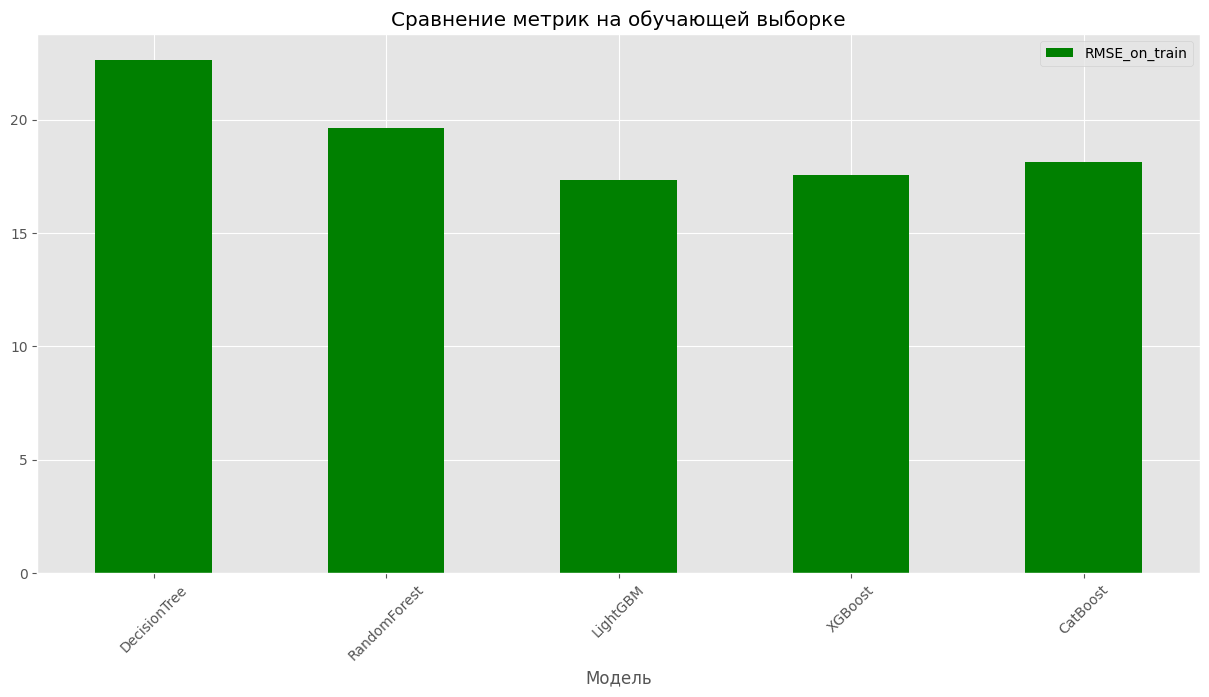

In [26]:
all_names = pd.DataFrame({'names':['DecisionTree', 'RandomForest', 'LightGBM', 'XGBoost', 'CatBoost']})
analisys = pd.concat([analisys, all_names], axis=1, join='inner')
display(analisys)

analisys.plot.bar(y='RMSE_model', x='names', rot=45, figsize=(15,7), color='red')
plt.title('Сравнение метрик моделей', fontsize='x-large')
plt.xlabel('Модель')
plt.show()

analisys.plot.bar(y='RMSE_on_train', x='names', rot=45, figsize=(15,7), color='green')
plt.title('Сравнение метрик на обучающей выборке', fontsize='x-large')
plt.xlabel('Модель')
plt.show()

Вывод:

Исходя из полученных моделей, лучше всего себя показала на рандомной модели - LightGBM с параметрами max_depth: 10 и learning_rate: 0.1 c количеством выборок для обучения TimeSeriesSplit - 24, потому для тестовой выборки будем использовать LightGBM.

Использование множества сплитов (TimeSeriesSplit) в модели LightGBM имеет свои преимущества при анализе временных рядов. Временной ряд обычно имеет внутренние зависимости и корреляции, которые необходимо учесть при обучении модели. Каждый сплит в TimeSeriesSplit создает разделение данных, где тренировочный набор содержит прошлые временные точки, а тестовый набор содержит будущие временные точки. Это позволяет модели учитывать временные зависимости при обучении и проверять ее способность обобщать и предсказывать будущие значения.

Использование большого количества сплитов (в данном случае 24) позволит модели более точно учесть временные закономерности и шаблоны в данных. Модель может обнаруживать сезонность, тренды и другие временные зависимости, что помогает в достижении более точных прогнозов и лучшей обобщающей способности модели.

Таким образом, использование множества сплитов в модели LightGBM с учетом временной структуры данных может значительно улучшить ее способность предсказывать будущие значения временного ряда.

## Тестирование

In [27]:
predicted = gbm_random.predict(test_features)
rmse_on_test = mean_squared_error(test_target, predicted, squared=False)
print('RMSE на тестовой выборке при использовании RandomizedSearchCV:', rmse_on_test)

Необходимая метрика получена, данную предобработку данных и текущую модель LightGBM можно использовать в дальнейшем.

Рассмотрим графики сравнения предсказаний и реальных значений:

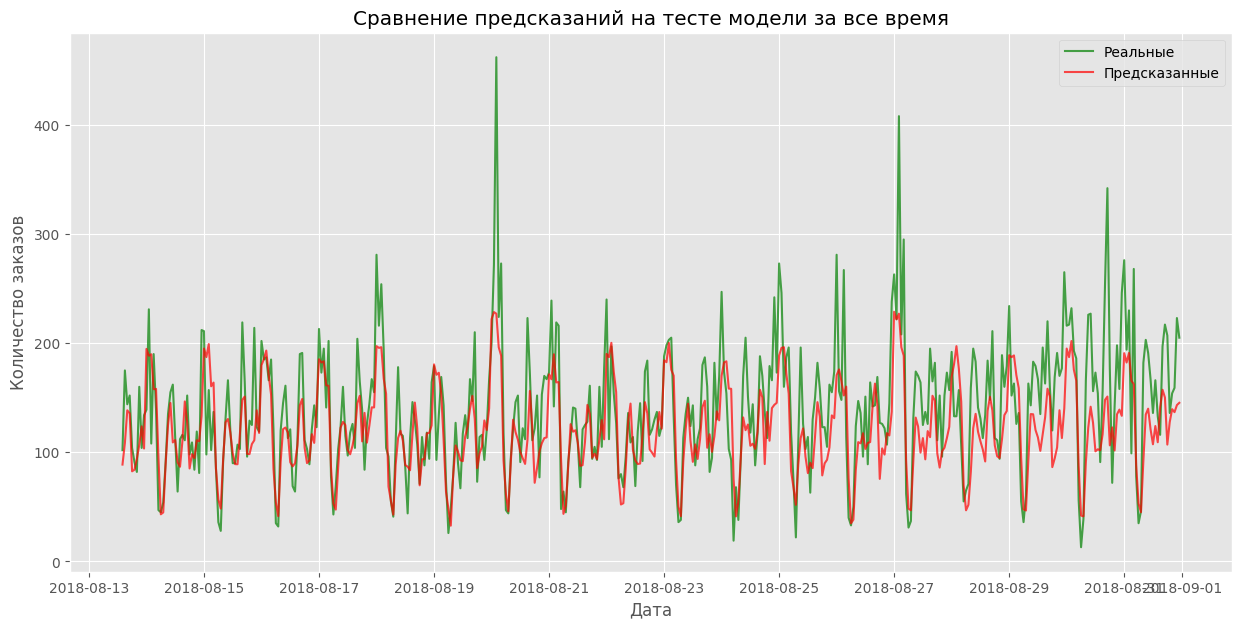

In [28]:
predicted = pd.DataFrame(predicted, index=test_features.index)

plt.figure(figsize=(15,7))
plt.plot(test_target, color='green', alpha=0.7)
plt.plot(predicted, color='red', alpha=0.7)
plt.title('Сравнение предсказаний на тесте модели за все время')
plt.ylabel('Количество заказов')
plt.xlabel('Дата')
plt.legend(['Реальные', 'Предсказанные'])
plt.show()

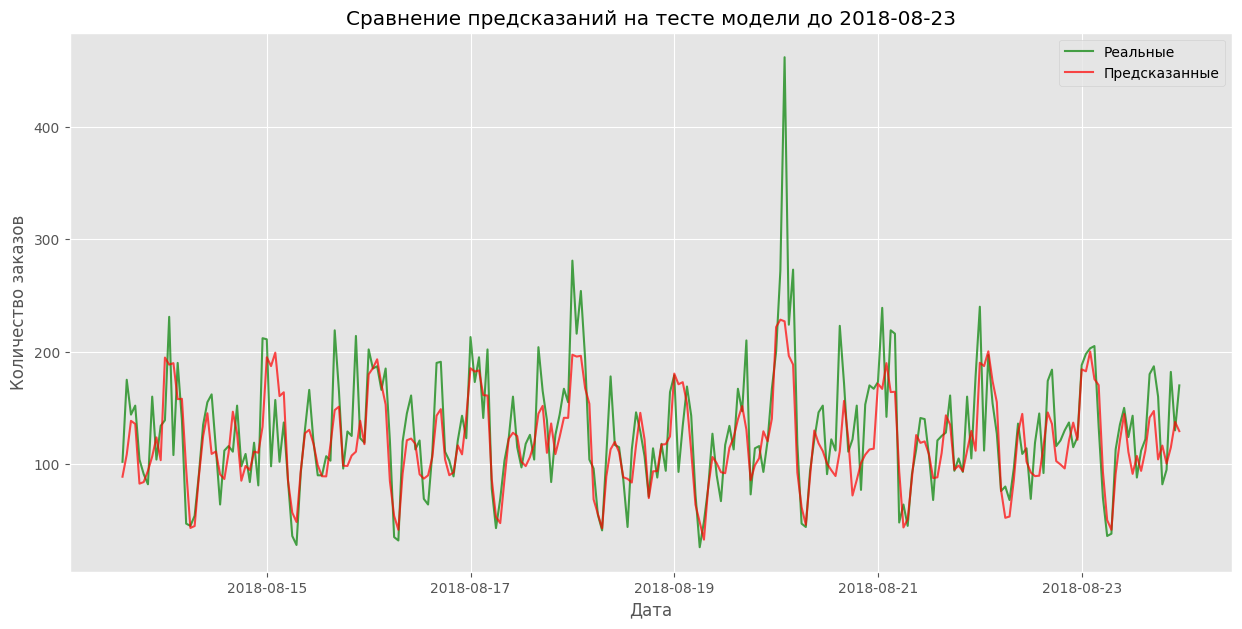

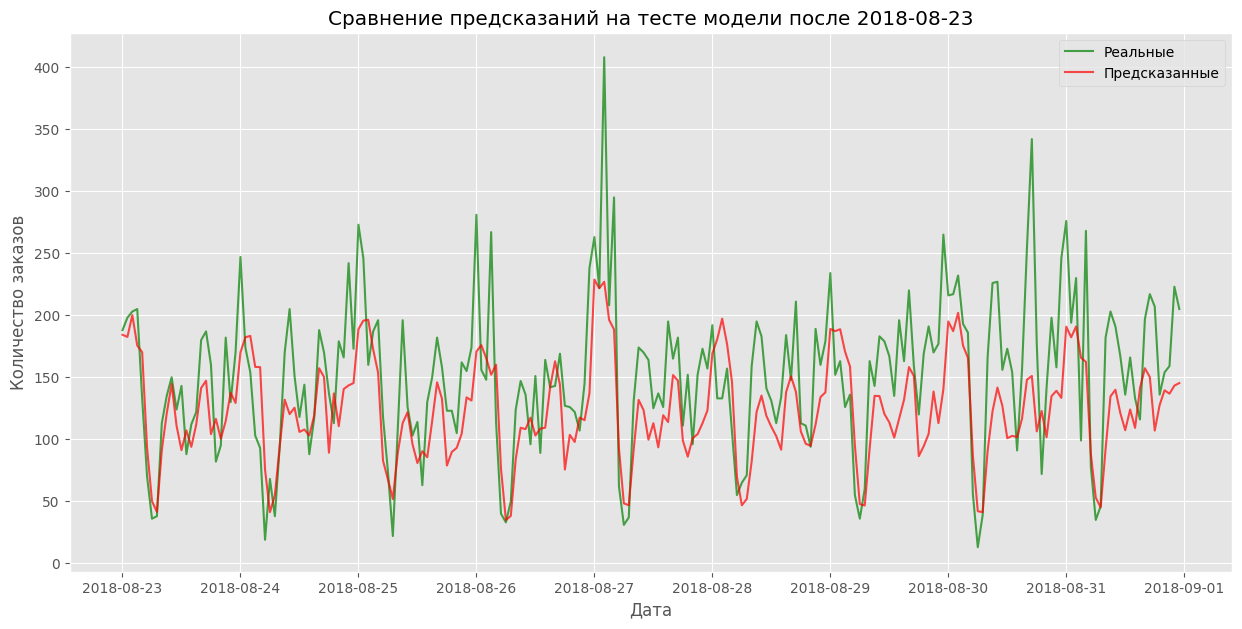

In [29]:
plt.figure(figsize=(15,7))
plt.plot(test_target[:'2018-08-23'], color='green', alpha=0.7)
plt.plot(predicted[:'2018-08-23'], color='red', alpha=0.7)
plt.title('Сравнение предсказаний на тесте модели до 2018-08-23')
plt.ylabel('Количество заказов')
plt.xlabel('Дата')
plt.legend(['Реальные', 'Предсказанные'])
plt.show()

plt.figure(figsize=(15,7))
plt.plot(test_target['2018-08-23':], color='green', alpha=0.7)
plt.plot(predicted['2018-08-23':], color='red', alpha=0.7)
plt.title('Сравнение предсказаний на тесте модели после 2018-08-23')
plt.ylabel('Количество заказов')
plt.xlabel('Дата')
plt.legend(['Реальные', 'Предсказанные'])
plt.show()

***Вывод:***

После загрузки данных и их ресемплирования по часам был выполнен анализ временных рядов. Различные модели были обучены с использованием разных гиперпараметров, а также была создана тестовая выборка размером 10% от исходных данных. После проверки данных на тестовой выборке были получены результаты.

Из всех протестированных моделей лучшие результаты показала модель LightGBM с оптимальными параметрами, подобранными с помощью GridSearchCV. Время подбора параметров составило 8.03 секунды, лучшее количество сплитов было равно 24. Полученные лучшие параметры модели: {'learning_rate': 0.1, 'max_depth': 10}. RMSE обученной модели составило 17.283307315435934, а RMSE на тренировочной выборке - 17.36408682552842.

В целом, RMSE модели составило 43.506. Однако, при анализе графиков можно заметить, что модель сильнее ошибается в областях с повышенным трендом роста заказов. Учитывая недостаток данных для точного прогнозирования повышения тренда заказов и непредсказуемые выбросы значений, модель все же демонстрирует недостаточную точность в некоторых сценариях.

***